In [1]:
from utitlity_functions import *
import numpy as np
from confectionery import Confectionery
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import scienceplots
import cv2 as cv
from matplotlib import cm
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
np.random.seed(137)

# input parameter

In [2]:
number_objs=1
objs=[np.load("data/Channel_31_10_2023_take_03_"+str(i)+".npy") for i in range(number_objs)]
normal_vector_trajectory=[np.load("data/Channel_31_10_2023_take_03_normal_vector_trajectory_"+str(i)+".npy") for i in range(number_objs)]
rotation_trajectory=[np.load("data/Channel_31_10_2023_take_03_rotation_trajectory_as_rotvec_"+str(i)+".npy") for i in range(number_objs)]
rotation_trajectory_gauss_filtered=[np.load("data/Channel_31_10_2023_take_03_rotation_trajectory_filtered_gauss_over_rotm_"+str(i)+".npy") for i in range(number_objs)]
koppenrath=Confectionery()
cut_radius=11

destination_pos_from_rot="data/Channel_31_10_2023_take_03_obj_pos_from_rot"


In [3]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
start_frames=[round(x[0,0]) for x in objs]
end_frames=[round(x[-1,0]) for x in objs]


In [4]:
X_true=[x[:,1] for x in objs]
Y_true=[x[:,2] for x in objs]
dX=[np.diff(x) for x in X_true]
dY=[np.diff(x) for x in Y_true]
L=[np.add.accumulate(np.sqrt(x**2+y**2)) for x,y in zip(dX,dY)]
L=[np.append(np.zeros(1),x) for x in L]



In [5]:
pos1=[]
L1=[]
for i in range(number_objs):
    v1_flat=np.copy(rotation_trajectory[i][:,[1,0]])
    v1_flat[:,1]=-v1_flat[:,1]
    normalization_factor=[np.linalg.norm(x) for x in v1_flat]
    normalization_factor=np.array([x if x>1e-6 else 1 for x in normalization_factor])
    v1_flat=v1_flat/normalization_factor[:,np.newaxis]

    r=np.mean(objs[i][:,-1])
    p_0=np.array([0,0,1])

    rotation_trajectory_dict=dict([[j,R.from_rotvec(r)] for j,r in enumerate(rotation_trajectory[i])])
    dist=distance_rot_on_sphere(p_0,rotation_trajectory_dict,r)
    L1.append(np.copy(dist))
    dist=dist[1:]-dist[:-1]

    V1=dist[:,np.newaxis]*v1_flat
    V1=np.concatenate((np.array([objs[i][0,1],objs[i][0,2]]).reshape((1,2)),V1),axis=0)
    pos1.append(np.add.accumulate(V1))


# save position position trajectory from rotation estimation

In [6]:
for i in range(number_objs):
    np.save(destination_pos_from_rot+"_"+str(i)+".npy",pos1[i])

In [7]:
pos2=[]
L2=[]
for i in range(number_objs):
    v1_flat=np.copy(rotation_trajectory_gauss_filtered[i][:,[1,0]])
    v1_flat[:,1]=-v1_flat[:,1]
    normalization_factor=[np.linalg.norm(x) for x in v1_flat]
    normalization_factor=np.array([x if x>1e-6 else 1 for x in normalization_factor])
    v1_flat=v1_flat/normalization_factor[:,np.newaxis]

    r=np.mean(objs[i][:,-1])
    p_0=np.array([0,0,1])

    rotation_trajectory_dict=dict([[j,R.from_rotvec(r)] for j,r in enumerate(rotation_trajectory_gauss_filtered[i])])
    dist=distance_rot_on_sphere(p_0,rotation_trajectory_dict,r)
    L2.append(np.copy(dist))
    dist=dist[1:]-dist[:-1]

    V1=dist[:,np.newaxis]*v1_flat
    V1=np.concatenate((np.array([objs[i][0,1],objs[i][0,2]]).reshape((1,2)),V1),axis=0)
    pos2.append(np.add.accumulate(V1))


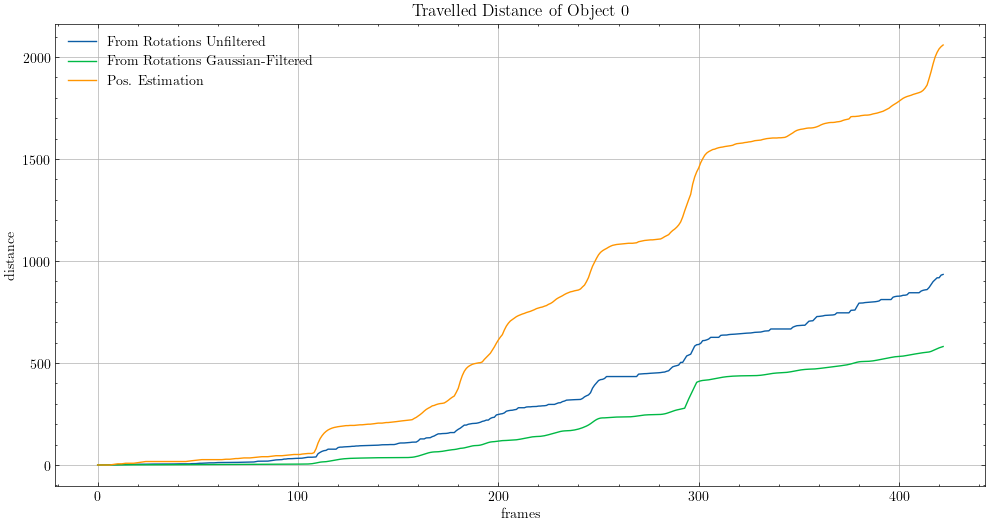

In [8]:
for i in range(number_objs):
    t=np.arange(L[i].size)
    with plt.style.context('science'):
        plt.rcParams['figure.figsize'] = [12,6]
        plt.xlabel("frames")
        plt.ylabel("distance")
        plt.plot(t,L1[i],label="From Rotations Unfiltered")
        plt.plot(t,L2[i],label="From Rotations Gaussian-Filtered")
        plt.plot(t,L[i],label="Pos. Estimation")
        plt.grid()
        plt.title("Travelled Distance of Object " +str(i))
        plt.legend()
        plt.show()

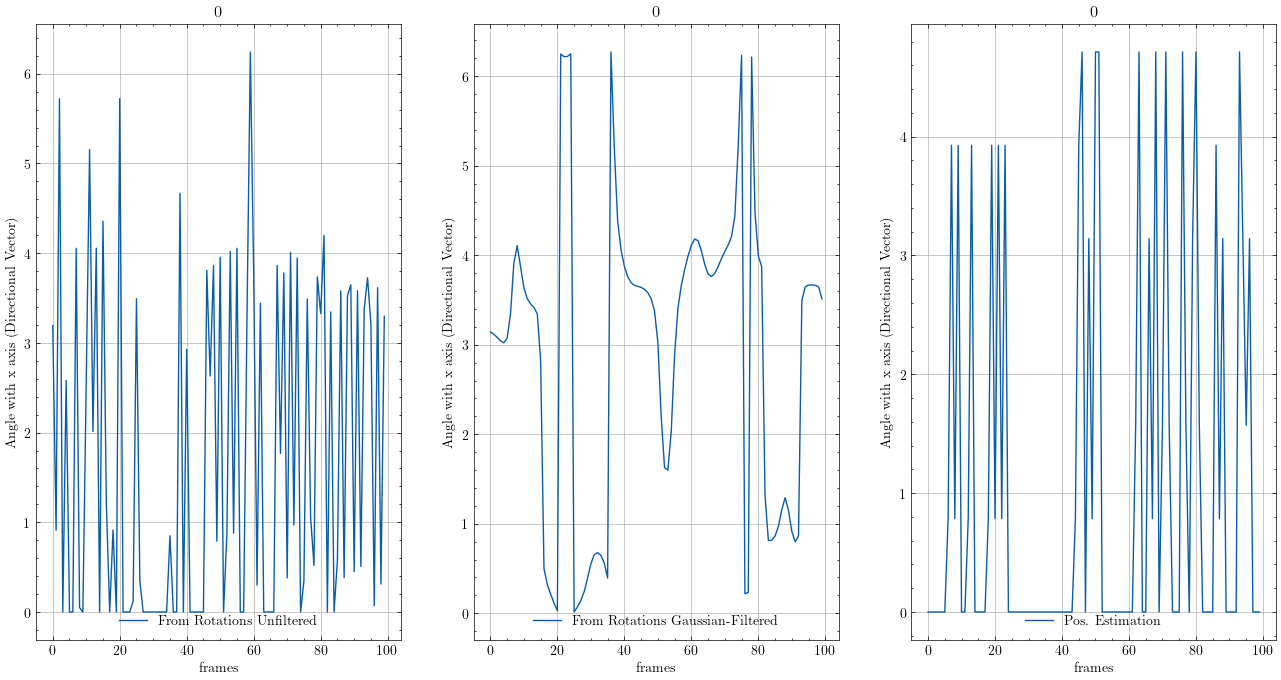

In [9]:
angle=[np.arctan2((y[1:]-y[:-1]), x[1:]-x[:-1])%(2*np.pi) for x,y in zip(X_true,Y_true)]
angle1=[np.arctan2((x[1:,1]-x[:-1,1]), x[1:,0]-x[:-1,0])%(2*np.pi) for x in pos1]
angle2=[np.arctan2((x[1:,1]-x[:-1,1]), x[1:,0]-x[:-1,0])%(2*np.pi) for x in pos2]

numer_of_displayed_frames=100

for i in range(number_objs):
    t=np.arange(start_frames[i],end_frames[i])
    with plt.style.context('science'):
        plt.rcParams['figure.figsize'] = [16, 8]
        fig,(ax1,ax2,ax3)=plt.subplots(1,3)
        ax1.set_xlabel("frames")
        ax1.set_ylabel("Angle with x axis (Directional Vector)")
        ax1.plot(t[:numer_of_displayed_frames],angle1[i][:numer_of_displayed_frames],label="From Rotations Unfiltered")
        ax1.grid()
        ax1.legend(loc="lower center")
        ax1.set_title(str(i))
        ax2.set_xlabel("frames")
        ax2.set_ylabel("Angle with x axis (Directional Vector)")
        ax2.plot(t[:numer_of_displayed_frames],angle2[i][:numer_of_displayed_frames],label="From Rotations Gaussian-Filtered")
        ax2.grid()
        ax2.legend(loc="lower center")
        ax2.set_title(str(i))
        ax3.set_xlabel("frames")
        ax3.set_ylabel("Angle with x axis (Directional Vector)")
        ax3.plot(t[:numer_of_displayed_frames],angle[i][:numer_of_displayed_frames],label="Pos. Estimation")
        ax3.grid()
        ax3.legend(loc="lower center")
        ax3.set_title(str(i))
        plt.show()

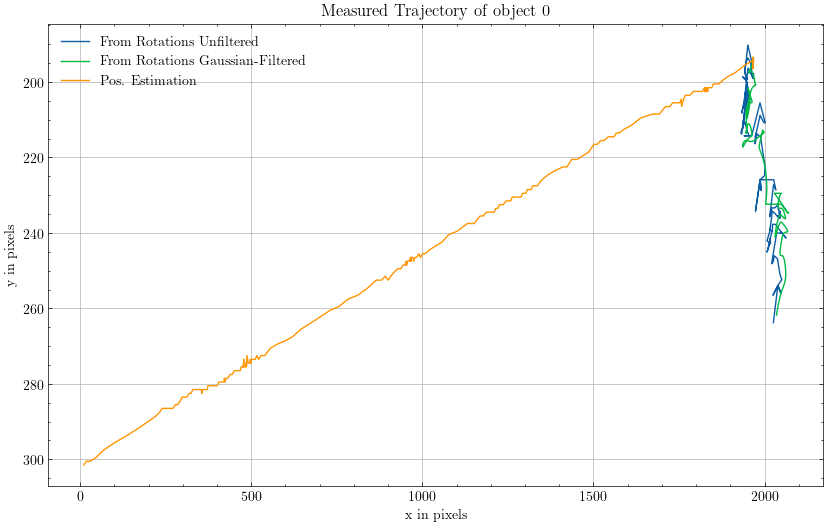

In [10]:
for i in range(number_objs):
    with plt.style.context('science'):
        plt.rcParams['figure.figsize'] = [10, 6]
        plt.xlabel("x in pixels")
        plt.ylabel("y in pixels")
        plt.plot(pos1[i][:,0],pos1[i][:,1],label="From Rotations Unfiltered")
        plt.plot(pos2[i][:,0],pos2[i][:,1],label="From Rotations Gaussian-Filtered")
        plt.plot(X_true[i],Y_true[i],label="Pos. Estimation")
        plt.grid()
        plt.gca().invert_yaxis()
        plt.title("Measured Trajectory of object " +str(i))
        plt.legend()
        plt.show()

# Pi corrected values

In [11]:

#index=((angle1-np.pi/2)%(2*np.pi))>=angle
#index=index*(((angle1+np.pi/2)%(2*np.pi))<=angle)

index1=[np.cos(x)*np.cos(y)+np.sin(x)*np.sin(y)<0 for x,y in zip(angle,angle1)]

angle1_corrected=[np.copy(x) for x in angle1]
for i in range(number_objs):
    angle1_corrected[i][index1[i]]=(angle1_corrected[i][index1[i]]+np.pi)%(2*np.pi)

index2=[np.cos(x)*np.cos(y)+np.sin(x)*np.sin(y)<0 for x,y in zip(angle,angle2)]
angle2_corrected=[np.copy(x) for x in angle1]
for i in range(number_objs):
    angle2_corrected[i][index2[i]]=(angle2_corrected[i][index2[i]]+np.pi)%(2*np.pi)



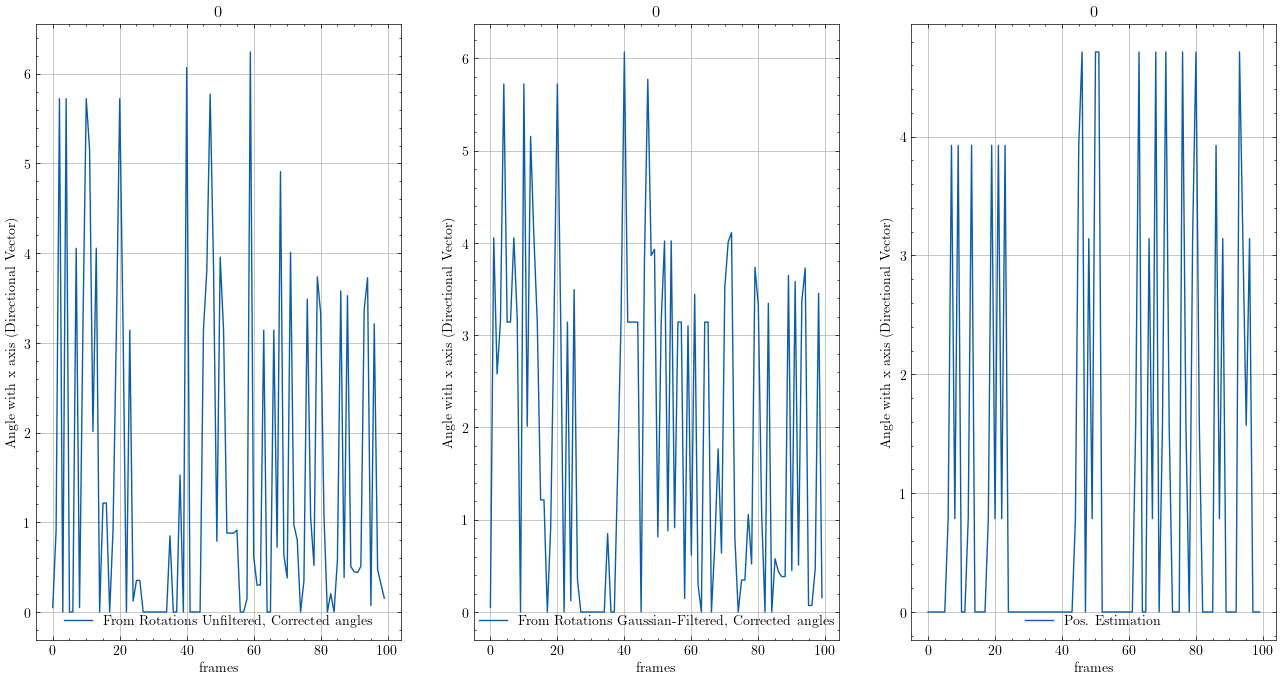

In [12]:
numer_of_displayed_frames=100

for i in range(number_objs):
    t=np.arange(start_frames[i],end_frames[i])
    with plt.style.context('science'):
        plt.rcParams['figure.figsize'] = [16, 8]
        fig,(ax1,ax2,ax3)=plt.subplots(1,3)
        ax1.set_xlabel("frames")
        ax1.set_ylabel("Angle with x axis (Directional Vector)")
        ax1.plot(t[:numer_of_displayed_frames],angle1_corrected[i][:numer_of_displayed_frames],label="From Rotations Unfiltered, Corrected angles")
        ax1.grid()
        ax1.legend(loc="lower center")
        ax1.set_title(str(i))
        ax2.set_xlabel("frames")
        ax2.set_ylabel("Angle with x axis (Directional Vector)")
        ax2.plot(t[:numer_of_displayed_frames],angle2_corrected[i][:numer_of_displayed_frames],label="From Rotations Gaussian-Filtered, Corrected angles")
        ax2.grid()
        ax2.legend(loc="lower center")
        ax2.set_title(str(i))
        ax3.set_xlabel("frames")
        ax3.set_ylabel("Angle with x axis (Directional Vector)")
        ax3.plot(t[:numer_of_displayed_frames],angle[i][:numer_of_displayed_frames],label="Pos. Estimation")
        ax3.grid()
        ax3.legend(loc="lower center")
        ax3.set_title(str(i))
        plt.show()

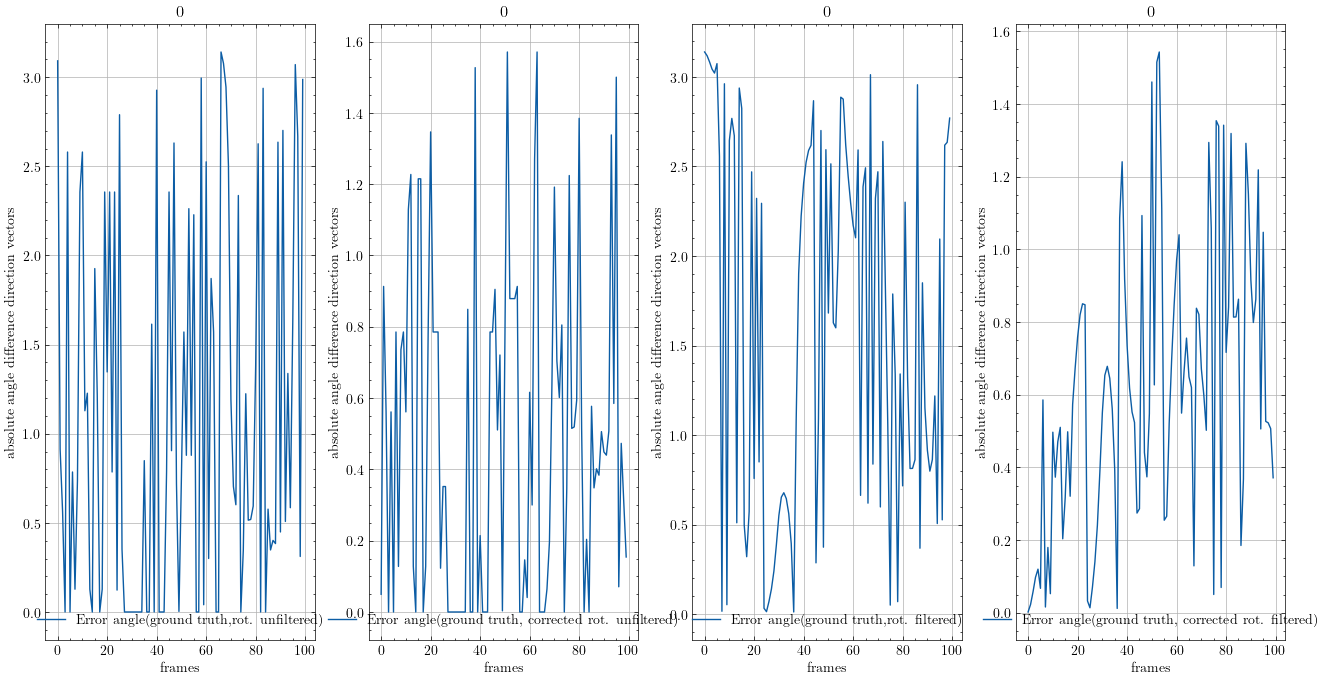

In [13]:
V=[np.array([np.cos(x),np.sin(x)]) for x in angle]
V1=[np.array([np.cos(x),np.sin(x)]) for x in angle1]
V1_corrected=[np.copy(x) for x in V1]
V2=[np.array([np.cos(x),np.sin(x)]) for x in angle2]
V2_corrected=[np.copy(x) for x in V2]
for i in range(number_objs):
    V1_corrected[i][:,index1[i]]=-V1_corrected[i][:,index1[i]]
    V2_corrected[i][:,index2[i]]=-V2_corrected[i][:,index2[i]]

e1_original=[np.arccos(np.sum(x*y,axis=0)) for x,y in zip(V,V1)]
e1_corrected=[np.arccos(np.sum(x*y,axis=0)) for x,y in zip(V,V1_corrected)]
e2_original=[np.arccos(np.sum(x*y,axis=0)) for x,y in zip(V,V2)]
e2_corrected=[np.arccos(np.sum(x*y,axis=0)) for x,y in zip(V,V2_corrected)]

for i in range(number_objs):
    t=np.arange(start_frames[i],end_frames[i])
    with plt.style.context('science'):
        plt.rcParams['figure.figsize'] = [16, 8]
        fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4)
        ax1.set_xlabel("frames")
        ax1.set_ylabel("absolute angle difference direction vectors")
        ax1.plot(t[:numer_of_displayed_frames],e1_original[i][:numer_of_displayed_frames],label="Error angle(ground truth,rot. unfiltered)")
        ax1.grid()
        ax1.legend(loc="lower center")
        ax1.set_title(str(i))
        ax2.set_xlabel("frames")
        ax2.set_ylabel("absolute angle difference direction vectors")
        ax2.plot(t[:numer_of_displayed_frames],e1_corrected[i][:numer_of_displayed_frames],label="Error angle(ground truth, corrected rot. unfiltered)")
        ax2.grid()
        ax2.legend(loc="lower center")
        ax2.set_title(str(i))
        ax3.set_xlabel("frames")
        ax3.set_ylabel("absolute angle difference direction vectors")
        ax3.plot(t[:numer_of_displayed_frames],e2_original[i][:numer_of_displayed_frames],label="Error angle(ground truth,rot. filtered)")
        ax3.grid()
        ax3.legend(loc="lower center")
        ax3.set_title(str(i))
        ax4.set_xlabel("frames")
        ax4.set_ylabel("absolute angle difference direction vectors")
        ax4.plot(t[:numer_of_displayed_frames],e2_corrected[i][:numer_of_displayed_frames],label="Error angle(ground truth, corrected rot. filtered)")
        ax4.grid()
        ax4.legend(loc="lower center")
        ax4.set_title(str(i))
        plt.show()

# ground trajectories pi corrected angles

In [14]:
pos1_corrected=[]
pos2_corrected=[]
for i in range(number_objs):
    rotation_trajectory_dict=dict([[j,R.from_rotvec(r)] for j,r in enumerate(rotation_trajectory[i])])
    dist=distance_rot_on_sphere(p_0,rotation_trajectory_dict,r)
    dr=dist[1:]-dist[:-1]
    X_corrected=np.copy(X_true[i])
    X_corrected[1:]=np.cos(angle1_corrected[i])*dr
    X_corrected=np.add.accumulate(X_corrected)
    Y_corrected=np.copy(Y_true[i])
    Y_corrected[1:]=np.sin(angle1_corrected[i])*dr
    Y_corrected=np.add.accumulate(Y_corrected)
    pos1_corrected.append(np.array([X_corrected,Y_corrected]))
for i in range(number_objs):
    rotation_trajectory_dict=dict([[j,R.from_rotvec(r)] for j,r in enumerate(rotation_trajectory_gauss_filtered[i])])
    dist=distance_rot_on_sphere(p_0,rotation_trajectory_dict,r)
    dr=dist[1:]-dist[:-1]
    X_corrected=np.copy(X_true[i])
    X_corrected[1:]=np.cos(angle2_corrected[i])*dr
    X_corrected=np.add.accumulate(X_corrected)
    Y_corrected=np.copy(Y_true[i])
    Y_corrected[1:]=np.sin(angle2_corrected[i])*dr
    Y_corrected=np.add.accumulate(Y_corrected)
    pos2_corrected.append(np.array([X_corrected,Y_corrected]))


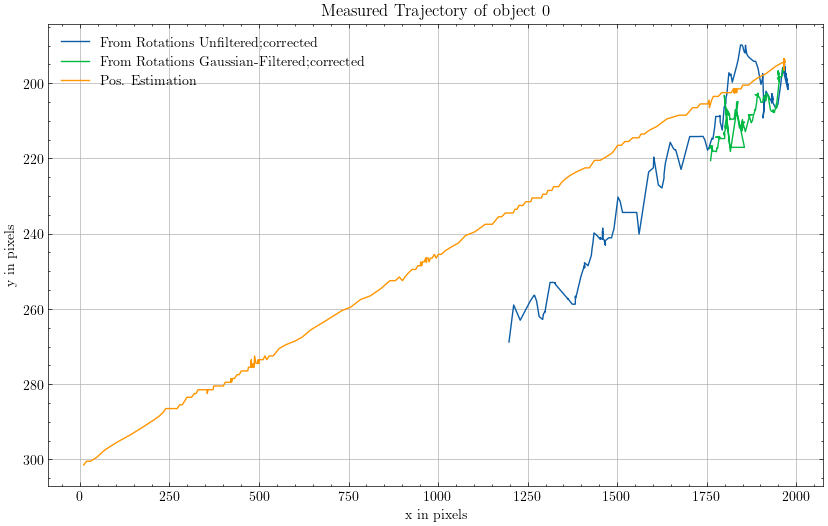

In [15]:
for i in range(number_objs):
    with plt.style.context('science'):
        plt.rcParams['figure.figsize'] = [10, 6]
        plt.xlabel("x in pixels")
        plt.ylabel("y in pixels")
        plt.plot(pos1_corrected[i][0,:],pos1_corrected[i][1,:],label="From Rotations Unfiltered;corrected")
        plt.plot(pos2_corrected[i][0,:],pos2_corrected[i][1,:],label="From Rotations Gaussian-Filtered;corrected")
        plt.plot(X_true[i],Y_true[i],label="Pos. Estimation")
        plt.grid()
        plt.gca().invert_yaxis()
        plt.title("Measured Trajectory of object " +str(i))
        plt.legend()
        plt.show()

# FROM HERE ON TODO

In [16]:
error_x=object_trajectory[:,1]-X_3
error_y=object_trajectory[:,2]-Y_3
error_euclidean_dist=np.sqrt(error_x**2+error_y**2)
t=np.arange(error_x.size)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.xlabel("Frame Number")
    plt.ylabel("Error(in pixels)")
    plt.plot(t,error_euclidean_dist)
    plt.grid()
    plt.title("Error(in pixels) euclidean distance")
    plt.show()


NameError: name 'object_trajectory' is not defined

In [ ]:
V=np.array([np.cos(angle),np.sin(angle)])
V1=np.array([np.cos(angle1),np.sin(angle1)])
V1_corrected=np.copy(V1)
V1_corrected[:,index]=-V1_corrected[:,index]

v_mean=np.mean(V,axis=1)
v1_mean=np.mean(V1,axis=1)
v1_corrected_mean=np.mean(V1_corrected,axis=1)

print(np.arctan2(v_mean[1],v_mean[0]))
print(np.arctan2(v1_mean[1],v1_mean[0]))
print(np.arctan2(v1_corrected_mean[1],v1_corrected_mean[0]))


# Discretized directions

In [ ]:
#directions=np.arange(0,360,10)
directions=np.arange(0,360,45)
directions=directions*(2*np.pi/360)
v_directions=np.array([np.cos(directions),np.sin(directions)])
v_directions=v_directions.reshape((2,1,-1))
V=np.array([np.cos(angle),np.sin(angle)]).reshape((2,-1,1))
V_index_discr=np.argmin(np.linalg.norm(V-v_directions,axis=0),axis=1)

X_true=object_trajectory[:,1]
Y_true=object_trajectory[:,2]
dX=np.diff(X_true)
dY=np.diff(Y_true)
dL=np.sqrt(dX**2+dY**2)
V_reconstructed=v_directions[:,0,V_index_discr]*dL
pos_reconstructed=np.concatenate((np.array([object_trajectory[0,1],object_trajectory[0,2]]).reshape((2,1)),V_reconstructed),axis=1)
pos_reconstructed=np.add.accumulate(pos_reconstructed,axis=1)

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.plot(pos_reconstructed[0,:],pos_reconstructed[1,:],label="Pos. Estimation Discretized")
    plt.plot(X_true,Y_true,label="Pos. Estimation")
    plt.grid()
    plt.gca().invert_yaxis()
    plt.title("Measured Trajectory")
    plt.legend()
    plt.show()

In [ ]:
V=np.array([np.cos(angle),np.sin(angle)]).reshape((2,-1,1))
V1=np.array([np.cos(angle1),np.sin(angle1)]).reshape((2,-1,1))
V1_corrected=np.array([np.cos(angle1_corrected),np.sin(angle1_corrected)]).reshape((2,-1,1))

V_index_discr=np.argmin(np.linalg.norm(V-v_directions,axis=0),axis=1)
V1_index_discr=np.argmin(np.linalg.norm(V1-v_directions,axis=0),axis=1)
V1_corrected_index_discr=np.argmin(np.linalg.norm(V1_corrected-v_directions,axis=0),axis=1)


In [ ]:
V_index_discr=V_index_discr
V1_index_discr=V1_index_discr
end_frame=300
t=np.arange(start_frame+1,end_frame+1)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.scatter(t,V_index_discr[:end_frame-start_frame])
    plt.scatter(t,V1_index_discr[:end_frame-start_frame])
    plt.grid()
    plt.title("Measured Trajectory")
    plt.show()


In [ ]:
V_index_discr=V_index_discr%4
V1_index_discr=V1_index_discr%4
end_frame=300
t=np.arange(start_frame+1,end_frame+1)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.scatter(t,V_index_discr[:end_frame-start_frame])
    plt.scatter(t,V1_index_discr[:end_frame-start_frame])
    plt.grid()
    plt.title("Measured Trajectory")
    plt.show()